In [1]:
from __future__ import unicode_literals, print_function, division
import unicodedata
import string
import re
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pickle
import lstm_utils


import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

In [2]:
# Globals:
MAX_LENGTH = 25 # No max length
PREFIX_CONSTRAINT = False
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

PAD_BATCH_DATA = True
BATCH_SIZE = 16
learning_rate = 1e-3
num_epochs = 18
train_loss = []
test_loss = []


teacher_forcing_ratio = 0.5
use_gpu = torch.cuda.is_available()

In [3]:
SOS_token = 0
EOS_token = 1
PAD_token = 2
UNK_token = 3

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
        self.n_words = len(self.index2word)  # Next entry will be 4

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [9]:
def readLangs(lang1, reverse=False):
    print("Reading lines...")
    
    # Split every line by tabs into pairs and normalize
    pairs = pickle.load(open('/media/asilva/HD_home/pairs.pkl', 'rb'))

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        language = Lang(lang1)
    else:
        language = Lang(lang1)

    return language, pairs

In [10]:
def filterPair(p):
    # If we have a max length and we only want to consider sentences that start with X
    if MAX_LENGTH > 0 and PREFIX_CONSTRAINT:
        return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)
    # If we have a max length
    elif MAX_LENGTH > 0:
        return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH
    # If we only want to consider sentences that start with X
    elif PREFIX_CONSTRAINT:
        return p[1].startswith(eng_prefixes)
    else:
        return True

def filterPairs(pairs):
    # For each pair, only include ones that we want for this model
    return [pair for pair in pairs if filterPair(pair)]

In [11]:
def prepareData(lang1, reverse=False):
    # Create Lang instances, read in all data
    language, pairs = readLangs(lang1, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    # Add pairs to each Lang instance (gives us word to index and index to word)
    for pair in pairs:
        language.addSentence(pair[0])
        language.addSentence(pair[1])
    print("Counted words:")
    print(language.name, language.n_words)
    return language, pairs


In [12]:
language, pairs = prepareData('english', True)
print(random.choice(pairs))
for pair in pairs:
    if len(pair[0].split()) > MAX_LENGTH:
        MAX_LENGTH = len(pair[0].split())
        print("PAIR0:", pair[0])
    if len(pair[1].split()) > MAX_LENGTH:
        MAX_LENGTH = len(pair[1].split())
        print("PAIR1:", pair[1])
print("Max length: %s" % MAX_LENGTH)

Reading lines...
Read 39408 sentence pairs
Trimmed to 21581 sentence pairs
Counted words:
english 5312
['at donetto or at your apartment ?', 'i visiting allie now !']
Max length: 25


In [72]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_gpu:
            return result.cuda()
        else:
            return result
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_gpu:
            return result.cuda()
        else:
            return result

In [103]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    indices = []
    if (type(sentence) is not unicode):
        sentence = unicode(sentence, "utf-8")
    sentence = normalizeString(sentence)
    for word in sentence.split():
        if word in lang.word2index:
            indices.append(lang.word2index[word])
        else:
            indices.append(lang.word2index['UNK'])
    return indices

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if use_gpu: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(language, pair[0])
    target_variable = variable_from_sentence(language, pair[1])
    return (input_variable, target_variable)

In [142]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_gpu else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_gpu else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            print("OUTPUT", decoder_output)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_gpu else decoder_input
            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [105]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [106]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [107]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(language, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_gpu else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_gpu else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encode_index][step_index]r_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(language.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_gpu else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

In [108]:
def evaluate_randomly(enc, dec):
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(enc, dec, pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [109]:
# Configuring training
n_iters = 50000
plot_every = 200
print_every = 1000
learning_rate = 1e-3
hidden_size = 256
encoder = EncoderRNN(language.n_words, hidden_size)
decoder = AttnDecoderRNN(hidden_size, language.n_words, dropout_p=0.2)


if use_gpu:
    encoder = encoder.cuda()
    decoder = decoder.cuda()


In [119]:
start = time.time()
plot_losses = []
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
training_pairs = [variables_from_pair(random.choice(pairs))
                  for i in range(n_iters)]
criterion = nn.NLLLoss().cuda()

In [143]:
for iteration in range(1, n_iters + 1):
    training_pair = training_pairs[iteration - 1]
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    loss = train(input_variable, target_variable, encoder,
                 decoder, encoder_optimizer, decoder_optimizer, criterion)
    print_loss_total += loss
    plot_loss_total += loss

    if iteration % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print('%s (%d %d%%) %.4f' % (timeSince(start, iteration / n_iters),
                                     iteration, iteration / n_iters * 100, print_loss_avg))

    if iteration % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

showPlot(plot_losses)

OUTPUT Variable containing:
-24.3707 -16.3311 -24.3746  ...  -23.6204 -23.5582 -24.3924
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 66
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-32.2818 -10.0740 -32.2201  ...  -30.3249 -29.6176 -31.8731
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 184
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-31.4214  -8.5890 -31.3545  ...  -30.6314 -28.0879 -29.1036
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 21
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-31.3003  -7.3263 -31.2478  ...  -30.7161 -28.0621 -29.9134
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 22
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-29.6145  -8.9114 -29.5861  ...  -28.8112 -27.0388 -27.3810
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variabl

OUTPUT Variable containing:
-43.1736 -12.4735 -43.0780  ...  -41.1301 -34.8663 -41.9436
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 22
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-38.7169 -15.7952 -38.7241  ...  -35.7960 -32.2012 -38.7768
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 846
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-34.8135  -7.1215 -34.8250  ...  -32.6364 -28.1703 -32.6959
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 77
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-32.6484  -7.4553 -32.6762  ...  -30.4666 -28.0784 -30.4258
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 151
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-33.4504  -6.6944 -33.4952  ...  -31.4848 -30.4728 -31.1766
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variab

OUTPUT Variable containing:
-29.7817 -12.9855 -29.7605  ...  -30.0860 -23.9172 -28.5696
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-33.0271  -7.7182 -33.0146  ...  -32.2932 -29.2276 -31.0075
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-33.3343  -5.6957 -33.2405  ...  -33.1875 -28.9243 -28.9963
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-30.3663  -4.3443 -30.3203  ...  -29.5778 -27.3937 -25.4529
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-33.1462  -8.4363 -33.1501  ...  -32.4415 -30.4184 -29.4755
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-33.2887  -0.1944 -33.2514  ...  -32.5101 -28.7726 -26.0917
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-28.8295 -14.1608 -28.7792  ...  -27.6063 -24.7527 -27.6131
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 819
[torch.c

OUTPUT Variable containing:
-24.2095 -14.6738 -24.2197  ...  -22.9278 -19.6254 -24.4922
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 48
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-28.7916 -12.8593 -28.8126  ...  -27.2773 -23.2252 -29.8305
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 12
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-30.2120 -12.4189 -30.2315  ...  -28.8171 -25.7054 -30.2568
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 325
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-31.1241  -7.3258 -31.1434  ...  -29.3862 -25.4304 -29.0825
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 21
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-24.8071  -5.0917 -24.8406  ...  -22.3957 -19.6503 -24.1287
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variabl

OUTPUT Variable containing:
-3.3524e+01 -2.2729e+01 -3.3529e+01  ...  -3.3226e+01 -3.0842e+01 -3.3276e+01
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 2329
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-30.3097  -8.1199 -30.3142  ...  -28.9488 -26.6109 -28.7988
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 26
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-28.7779  -7.7366 -28.7614  ...  -27.9786 -26.7596 -26.7720
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 71
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-26.4471  -7.6939 -26.4433  ...  -25.3046 -23.7460 -23.9110
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 280
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-28.2159  -5.9676 -28.1825  ...  -27.0413 -24.6926 -25.0756
[torch.cuda.FloatTensor of size 1x5312 (GPU

OUTPUT Variable containing:
-32.1381  -9.3578 -32.1065  ...  -30.7493 -28.4365 -29.4142
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-25.2242 -11.0678 -25.2518  ...  -23.3786 -22.0201 -23.6232
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-29.9643  -9.4995 -29.9698  ...  -28.5964 -24.6621 -26.4068
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-30.5963  -6.5189 -30.5843  ...  -28.6832 -27.8454 -26.5158
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-27.7229  -6.5707 -27.7261  ...  -26.0238 -24.9664 -25.0668
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-29.7589  -6.2200 -29.7137  ...  -28.3298 -24.9618 -24.6298
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-30.8054  -5.8881 -30.7796  ...  -28.7443 -27.8694 -24.8904
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-30.9852  -1.

OUTPUT Variable containing:
-29.9403  -6.8581 -30.0257  ...  -28.0700 -26.2120 -27.0171
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-33.4297  -5.7041 -33.4586  ...  -32.1538 -28.6141 -29.6417
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-26.6190  -3.6204 -26.7565  ...  -25.6949 -23.6499 -23.5232
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-27.8720  -4.8594 -27.9625  ...  -26.0669 -26.1041 -21.9782
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-31.7705  -3.2306 -31.8332  ...  -29.8667 -28.3651 -24.2272
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-32.2981  -2.2147 -32.3579  ...  -29.8734 -28.4757 -24.2526
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-30.5066  -1.6211 -30.5754  ...  -27.9709 -27.0627 -23.7809
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

OUTPUT Variable containing:
-33.3624  -0.

OUTPUT Variable containing:
-31.3787  -7.8894 -31.4312  ...  -30.4830 -26.7806 -30.2803
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 263
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-34.7159  -3.9756 -34.6550  ...  -33.5175 -31.2477 -30.5974
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 65
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-32.0958  -4.0382 -32.0843  ...  -30.6133 -27.9204 -29.8746
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 88
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-29.1895  -5.4846 -29.1936  ...  -27.9937 -24.9025 -25.5578
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable containing:
 7
[torch.cuda.LongTensor of size 1 (GPU 0)]

OUTPUT Variable containing:
-31.1372  -1.4040 -31.1856  ...  -29.2785 -25.7921 -28.3836
[torch.cuda.FloatTensor of size 1x5312 (GPU 0)]

TARGET Variable

KeyboardInterrupt: 

In [112]:
lstm_utils.save_checkpoint({
        'epoch':1,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'encoder_optimizer': encoder_optimizer.state_dict(),
        'decoder_optimizer': decoder_optimizer.state_dict(),
    }, filename='me_chatbot.pth.tar')


In [154]:
evaluate_randomly(encoder, decoder)

> i m gonna just say yes and that it means reducing the maximum volatility . . .
= do you know what minimizing the maximum volatility means ?
< do you know means minimizing you don t want to do ? <EOS>



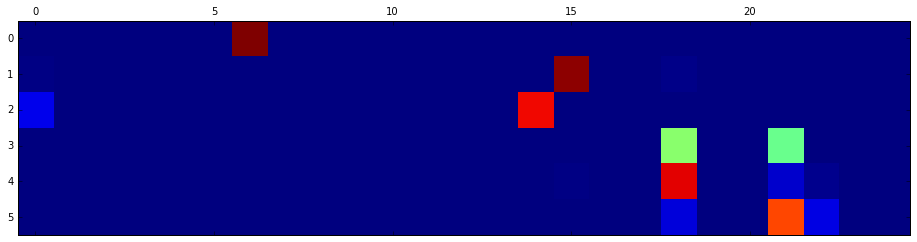

In [114]:
output_words, attentions = evaluate(
    encoder, decoder, "what s up")
plt.matshow(attentions.numpy())

input = what s up
output = are you could to take there <EOS>


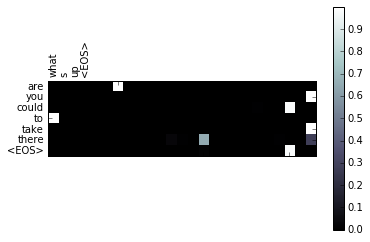

input = how are you?
output = yeah that s true <EOS>


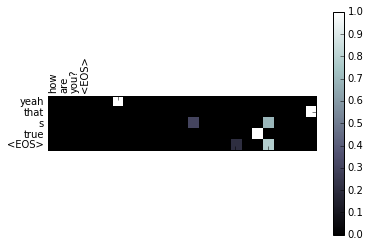

input = what are you doing?
output = they was climbing for us know sure <EOS>


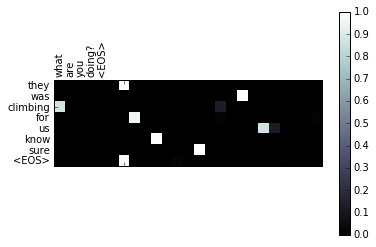

input = where is kayla
output = it s not steve you back ? <EOS>


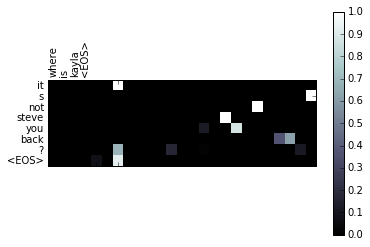

In [139]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("what s up")

evaluateAndShowAttention("how are you?")

evaluateAndShowAttention("what are you doing?")

evaluateAndShowAttention("where is kayla")